In [1]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
from PIL import Image
import datetime
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as func
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim

from models import VGG
from train import train1Epoch
from datasetCreator import ImageSubset
torch.cuda.empty_cache()

import os
import cv2

In [2]:
os.listdir('../../..')

['.gitconfig',
 '.config',
 'teams',
 '.keras',
 'private',
 '.cache',
 '.jupyter',
 '.bash_history',
 '.python_history',
 '.nv',
 '.local',
 '.ipython',
 'dsc10-2022-fa',
 'public',
 '.conda']

In [3]:
with open('../../../teams/dsc-180a---a14-[88137]/example.txt') as f:
    lines = f.readlines()

In [4]:
lines

['hey this is Yash\n']

In [5]:
test_csv = pd.read_csv('../../../teams/dsc-180a---a14-[88137]/BNPP_DT_test_with_ages.csv')
valid_csv = pd.read_csv('../../../teams/dsc-180a---a14-[88137]/BNPP_DT_val_with_ages.csv')
train_csv = pd.read_csv('../../../teams/dsc-180a---a14-[88137]/BNPP_DT_train_with_ages.csv')
h5py = h5py.File('../../../teams/dsc-180a---a14-[88137]/bnpp_frontalonly_1024_10.hdf5')
train_csv

,unique_key,bnpp_value_log,BNPP_weight,PNA_mask,PNA_wight_mask,BNP_value,age_at_sampletime
0,Flodure_51396672_img1,0.690196,1,None,1,4.9,45
1,Okepik_50995691_img1,0.690196,1,None,1,4.9,53
2,Kuesluco_51713925_img1,0.690196,1,None,1,4.9,54
3,Gumepra_51602745_img1,0.690196,1,None,1,4.9,58
4,Gapeklik_51060218_img1,0.690196,1,None,1,4.9,19
...,...,...,...,...,...,...,...
21369,Puesrueci_53095611_img1,4.845099,1,None,1,70000.1,57
21370,Adakas_52269723_img1,4.845099,1,None,1,70000.1,73
21371,Ekugud_52967627_img1,4.845099,1,None,1,70000.1,53
21372,Beguchouf_52038583_img1,4.845099,1,None,1,70000.1,60


In [6]:
train = train_csv[['unique_key','bnpp_value_log']]
train

,unique_key,bnpp_value_log
0,Flodure_51396672_img1,0.690196
1,Okepik_50995691_img1,0.690196
2,Kuesluco_51713925_img1,0.690196
3,Gumepra_51602745_img1,0.690196
4,Gapeklik_51060218_img1,0.690196
...,...,...
21369,Puesrueci_53095611_img1,4.845099
21370,Adakas_52269723_img1,4.845099
21371,Ekugud_52967627_img1,4.845099
21372,Beguchouf_52038583_img1,4.845099


#list(h5py.keys())
data = {}
ind=0
for key in list(h5py.keys()):
    image = Image.fromarray(f[key][:])
    #resizing to 224 x 224
    #formatted = (image * 255 / np.max(image)).astype('uint8')
    #img = Image.fromarray(formatted).resize((224,224))
    
    data[ind]=[key,image]
    #img_tensor = transform(img)
    #data[key] = img_tensor
    #img.save(f'data/images/{key}.jpg')

    ind+=1
data=pd.DataFrame(data).T
data.columns = ['patientID','image']
merged = data.merge(train, how='inner',left_on='patientID',right_on='unique_key')
merged

transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])
train_data = ImageSubset(csv_file = 'data/BNPP_DT_train_with_ages.csv', data=data, img_dir='data/images/')
train_data

In [7]:
batch_size = 8 #maybe change to 16, 8

# train_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.5), std=(0.5))
#     ])

train_set = ImageSubset(csv_file = train_csv, h5py_file = h5py) #, transform = train_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)

# valid_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.5), std=(0.5))
#     ])

valid_set = ImageSubset(csv_file = valid_csv, h5py_file = h5py) #, transform = valid_transform)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=0)

print(train_set[0])
#print(iter(train_loader).next())
#print(train.__getitem__(0))

(tensor([[[0.0408, 0.0238, 0.0134,  ..., 0.0067, 0.0071, 0.0073],
         [0.0375, 0.0228, 0.0111,  ..., 0.0064, 0.0057, 0.0095],
         [0.0374, 0.0216, 0.0106,  ..., 0.0077, 0.0059, 0.0093],
         ...,
         [0.2559, 0.1940, 0.1389,  ..., 0.0757, 0.0761, 0.0763],
         [0.4298, 0.3650, 0.2968,  ..., 0.2172, 0.2197, 0.2223],
         [0.6933, 0.6342, 0.5987,  ..., 0.5284, 0.5373, 0.5556]]]), 3.669409867287782)


In [8]:
a = np.array([1])

In [9]:
np.append(a,2)

array([1, 2])

from torchvision.io import read_image
from torchvision.models import vgg16

img = read_image(train_set[0])

# Step 1: Initialize model with the best available weights
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = preprocess(img).unsqueeze(0)

# Step 4: Use the model and print the predicted category
prediction = model(batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")

#example from Pytorch Website
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, num_workers=2)

#print(iter(training_loader).next(), training_loader)
#print(training_set.__getitem__(0))

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = VGG('VGG16').to(device)
model

cuda


VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1,

3.29  3.26  4.36  3.28  2.16  3.25  2.47  1.90


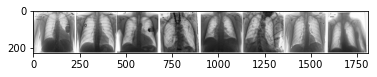

In [11]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels = dataiter.next()

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(str('%.2f' % labels[j].item()) for j in range(batch_size)))

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO]: Computation device: {device}")
epochs = 10 #40-50 epochs

total_params = sum(p.numel() for p in model.parameters())
print(f"[INFO]: {total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"[INFO]: {total_trainable_params:,} trainable parameters.")

# the loss function, Mean Absolute Error
loss_fn = nn.L1Loss()

# the optimizer
# need to tune optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.0001)

[INFO]: Computation device: cuda
[INFO]: 17,241,085 total parameters.
[INFO]: 17,241,085 trainable parameters.


# training
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        #print(data)

        image, bnpp = data
        image, bnpp = image.to(device), bnpp.to(device)
        print(image,bnpp)
        #print(i)
        #print(data)
        #print(data[0])
        #print(data[1])
        #print(data[2])
        #break
        image = image.to(device)
        bnpp = bnpp.to(device)

        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        #outputs = model(image.float())
        # calculate the loss
        loss = loss_fn(outputs, bnpp)
        train_running_loss += loss.item()
        # calculate the accuracy
        #_, preds = torch.max(outputs.data, 1)
        #train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()

    epoch_loss = train_running_loss / counter
    #epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss

In [13]:
torch.cuda.empty_cache()
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 50
best_vloss = 1_000_000.

tlosses, vlosses=[],[]

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    for param in model.parameters():
        param.requires_grad = True
    
    avg_loss = train1Epoch(epoch_number, model, optimizer, loss_fn, train_loader, writer)
    #print(avg_loss)
    #print(torch.cuda.memory_summary())
    # We don't need gradients on to do reporting
    for param in model.parameters():
        param.requires_grad = False
        
    model.train(False)

    running_vloss = 0.0
    val_losses = np.array([])
    for i, (vinputs,vlabels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        #vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels).detach() # took out voutputs.squeeze()
        running_vloss += vloss
        #print(type(vloss))
        #print(f"{vloss=}")
        #val_losses.append(vloss)
        val_losses = np.append(val_losses, vloss.cpu().numpy())
        vinputs.detach()
        vlabels.detach()

    avg_vloss = np.mean(val_losses)
    #print(torch.cuda.memory_summary())
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    tlosses.append(avg_loss)
    vlosses.append(avg_vloss)

    # Log the running loss averaged per batch
    # for both training and validation
    #writer.add_scalars('Training vs. Validation Loss',
    #                { 'Training' : avg_loss, 'Validation' : avg_vloss },
    #                epoch_number + 1)
    #writer.add_figure(tag='Train Loss',
    #                figure=plt.scatter(epoch,avg_loss))
    #writer.add_figure(tag='Validation Loss',
    #                figure=plt.scatter(epoch,avg_vloss))
    #writer.flush()

    # Track best performance, and save the model's state
#     if avg_vloss < best_vloss:
#         best_vloss = avg_vloss
#         model_path = 'model_{}_{}'.format(timestamp, epoch_number)
#         torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


  0%|          | 0/10 [00:00<?, ?it/s]/home/ypotdar/.local/lib/python3.9/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
 90%|█████████ | 9/10 [00:00<00:00, 17.33it/s]/home/ypotdar/.local/lib/python3.9/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
100%|██████████| 10/10 [00:00<00:00, 19.44it/s]


LOSS train 1.409052953753673 valid 1.0658888697624207
EPOCH 2:


100%|██████████| 10/10 [00:00<00:00, 14.82it/s]


LOSS train 1.2258522753984156 valid 0.8543759047985077
EPOCH 3:


100%|██████████| 10/10 [00:00<00:00, 17.27it/s]


LOSS train 1.1705425264130176 valid 0.9314586043357849
EPOCH 4:


100%|██████████| 10/10 [00:00<00:00, 16.47it/s]


LOSS train 1.1599607845427284 valid 0.874489888548851
EPOCH 5:


100%|██████████| 10/10 [00:00<00:00, 17.13it/s]


LOSS train 1.086888293145408 valid 0.8294712841510773
EPOCH 6:


100%|██████████| 10/10 [00:00<00:00, 19.57it/s]


LOSS train 1.1483243720632204 valid 0.8534879922866822
EPOCH 7:


100%|██████████| 10/10 [00:00<00:00, 17.33it/s]


LOSS train 1.0840958852163503 valid 0.8692598283290863
EPOCH 8:


100%|██████████| 10/10 [00:00<00:00, 20.42it/s]


LOSS train 1.1224411121556457 valid 0.9167219400405884
EPOCH 9:


100%|██████████| 10/10 [00:00<00:00, 19.07it/s]


LOSS train 1.0899451660438322 valid 0.8576674550771713
EPOCH 10:


100%|██████████| 10/10 [00:00<00:00, 17.30it/s]


LOSS train 1.0571145415306091 valid 0.972840529680252
EPOCH 11:


100%|██████████| 10/10 [00:00<00:00, 20.52it/s]


LOSS train 1.0015000650580501 valid 0.9134824246168136
EPOCH 12:


100%|██████████| 10/10 [00:00<00:00, 22.02it/s]


LOSS train 1.0008727009867278 valid 0.8615331739187241
EPOCH 13:


100%|██████████| 10/10 [00:00<00:00, 17.74it/s]


LOSS train 1.0247182128295091 valid 0.9127551674842834
EPOCH 14:


100%|██████████| 10/10 [00:00<00:00, 17.93it/s]


LOSS train 0.9725632516431136 valid 0.8274601548910141
EPOCH 15:


100%|██████████| 10/10 [00:00<00:00, 18.60it/s]


LOSS train 1.0385081726060787 valid 0.8549796134233475
EPOCH 16:


100%|██████████| 10/10 [00:00<00:00, 20.51it/s]


LOSS train 1.0259946740009416 valid 0.8775045663118363
EPOCH 17:


100%|██████████| 10/10 [00:00<00:00, 19.02it/s]


LOSS train 0.9763143037406492 valid 0.9418392598628997
EPOCH 18:


100%|██████████| 10/10 [00:00<00:00, 17.23it/s]


LOSS train 1.0036350983968922 valid 0.8287761479616165
EPOCH 19:


100%|██████████| 10/10 [00:00<00:00, 18.74it/s]


LOSS train 1.0302893779647182 valid 0.8755689531564712
EPOCH 20:


100%|██████████| 10/10 [00:00<00:00, 16.94it/s]


LOSS train 0.9460590674843586 valid 0.9784789741039276
EPOCH 21:


100%|██████████| 10/10 [00:00<00:00, 23.53it/s]


LOSS train 1.0145360059301618 valid 1.0637780487537385
EPOCH 22:


100%|██████████| 10/10 [00:00<00:00, 20.71it/s]


LOSS train 0.9629642119709875 valid 0.9113535284996033
EPOCH 23:


100%|██████████| 10/10 [00:00<00:00, 20.66it/s]


LOSS train 0.9593692291790331 valid 0.8651636362075805
EPOCH 24:


100%|██████████| 10/10 [00:00<00:00, 20.47it/s]


LOSS train 0.9408353273297699 valid 0.8999478578567505
EPOCH 25:


100%|██████████| 10/10 [00:00<00:00, 20.81it/s]


LOSS train 0.9507965479098576 valid 0.9925178587436676
EPOCH 26:


100%|██████████| 10/10 [00:00<00:00, 20.60it/s]


LOSS train 0.8994121211515346 valid 1.04280566573143
EPOCH 27:


100%|██████████| 10/10 [00:00<00:00, 22.26it/s]


LOSS train 0.9349305457632306 valid 1.0261986553668976
EPOCH 28:


100%|██████████| 10/10 [00:00<00:00, 18.32it/s]


LOSS train 0.942125184015489 valid 0.9493132412433625
EPOCH 29:


100%|██████████| 10/10 [00:00<00:00, 18.91it/s]


LOSS train 0.940192634790716 valid 0.9163873493671417
EPOCH 30:


100%|██████████| 10/10 [00:00<00:00, 17.23it/s]


LOSS train 0.9205764372583846 valid 0.9334775030612945
EPOCH 31:


100%|██████████| 10/10 [00:00<00:00, 19.55it/s]


LOSS train 0.8894901645015663 valid 0.8932424634695053
EPOCH 32:


100%|██████████| 10/10 [00:00<00:00, 16.58it/s]


LOSS train 0.8788224949803151 valid 0.9075825393199921
EPOCH 33:


100%|██████████| 10/10 [00:00<00:00, 21.52it/s]


LOSS train 0.9222490657383288 valid 0.8666888147592544
EPOCH 34:


100%|██████████| 10/10 [00:00<00:00, 20.19it/s]


LOSS train 0.8775102894910625 valid 0.9123559772968293
EPOCH 35:


100%|██████████| 10/10 [00:00<00:00, 19.02it/s]


LOSS train 0.8992421836920188 valid 0.8891542494297028
EPOCH 36:


100%|██████████| 10/10 [00:00<00:00, 19.47it/s]


LOSS train 0.8662873699631489 valid 0.8841499328613281
EPOCH 37:


100%|██████████| 10/10 [00:00<00:00, 19.51it/s]


LOSS train 0.8480653468991669 valid 0.9196758508682251
EPOCH 38:


100%|██████████| 10/10 [00:00<00:00, 19.22it/s]


LOSS train 0.8349489338800941 valid 1.049885904788971
EPOCH 39:


100%|██████████| 10/10 [00:00<00:00, 19.73it/s]


LOSS train 0.8574384387949823 valid 0.9356202095746994
EPOCH 40:


100%|██████████| 10/10 [00:00<00:00, 20.23it/s]


LOSS train 0.8715200474564458 valid 0.8481360495090484
EPOCH 41:


100%|██████████| 10/10 [00:00<00:00, 23.34it/s]


LOSS train 0.8552547558932238 valid 0.9701207399368286
EPOCH 42:


100%|██████████| 10/10 [00:00<00:00, 20.18it/s]


LOSS train 0.8838533314181046 valid 0.9791382789611817
EPOCH 43:


100%|██████████| 10/10 [00:00<00:00, 20.28it/s]


LOSS train 0.8946952828219239 valid 0.8578938841819763
EPOCH 44:


100%|██████████| 10/10 [00:00<00:00, 20.16it/s]


LOSS train 0.8208701249579309 valid 1.1270704507827758
EPOCH 45:


100%|██████████| 10/10 [00:00<00:00, 18.79it/s]


LOSS train 0.8773176674271973 valid 0.9255133390426635
EPOCH 46:


100%|██████████| 10/10 [00:00<00:00, 19.14it/s]


LOSS train 0.8808566743219403 valid 0.9306976526975632
EPOCH 47:


100%|██████████| 10/10 [00:00<00:00, 19.92it/s]


LOSS train 0.819237813143663 valid 0.9063922762870789
EPOCH 48:


100%|██████████| 10/10 [00:00<00:00, 20.79it/s]


LOSS train 0.7934211043404861 valid 0.9019008666276932
EPOCH 49:


100%|██████████| 10/10 [00:00<00:00, 20.23it/s]


LOSS train 0.8480303946515204 valid 1.0716197311878204
EPOCH 50:


100%|██████████| 10/10 [00:00<00:00, 20.53it/s]

LOSS train 0.8531847999129497 valid 0.8844708800315857


Text(0.5, 1.0, 'Losses for Training and Validation Data Throughout 50 Epochs')

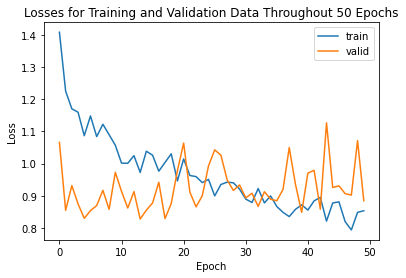

In [14]:
plt.plot(tlosses,label='train')
plt.plot(vlosses,label='valid')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses for Training and Validation Data Throughout 50 Epochs')

# save the trained model to disk
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_fn,
            }, '../outputs/VGG16Reg.pth')
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(
    train_acc, color='green', linestyle='-', 
    label='train accuracy'
)
plt.plot(
    valid_acc, color='blue', linestyle='-', 
    label='validataion accuracy'
)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('../outputs/accuracy.jpg')
plt.show()
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(
    train_loss, color='orange', linestyle='-', 
    label='train loss'
)
plt.plot(
    valid_loss, color='red', linestyle='-', 
    label='validataion loss'
)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../outputs/loss.jpg')
plt.show()
 
print('TRAINING COMPLETE')

#to load saved model
saved_model = VGG()
saved_model.load_state_dict(torch.load(PATH))